## Import modules

In [1]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
# for classification and clustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans

# to track progress
from tqdm.notebook import tqdm

## get and read data

get data

In [2]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip downloaded
folder extracted from zip


read data

In [3]:
# arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')
print(train_meta)

Dataset: CharacterTrajectories
	CharacterTrajectories_attribute's type is relational
	target's type is nominal, range is ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')



In [4]:
train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

# convert to np array
train_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_inputs])
test_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_inputs])

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

# subtract 1 from labels to start indexing from 0
train_labels -= 1; test_labels -= 1
print("labels :  ", np.unique(train_labels))

labels :   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


max length = 180


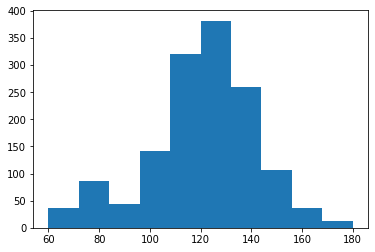

In [5]:
# Distribution of sample lenghts
lengths = []

for input in train_inputs:
  len1 = np.where(np.isnan(input[0]))[0][0]
  lengths.append(len1)

max_len = np.max(lengths)
print('max length =',max_len)
_ = plt.hist(lengths)

In [6]:
train_inputs = np.nan_to_num(train_inputs)
test_inputs = np.nan_to_num(test_inputs)

# split train into train and validation
train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_inputs),'samples')
print('\val data contains',len(val_inputs),'samples')
print('test data contains',len(test_inputs),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is',len(train_inputs[0][0]))
print('nan values have been replaced by 0')

number of classes : 20

train data contains 1066 samples
al data contains 356 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force
length of each channel is 182
nan values have been replaced by 0


## visualize characters

print and plot first sample

[[0.041938 0.041907 0.033162 ... 0.       0.       0.      ]
 [0.07612  0.094818 0.105972 ... 0.       0.       0.      ]
 [0.978557 1.169149 1.250145 ... 0.       0.       0.      ]]


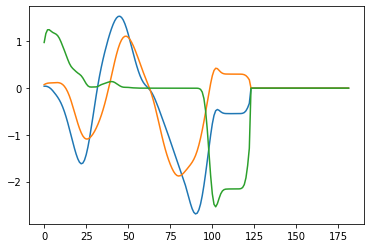

In [7]:
np.set_printoptions(threshold=10)
print(train_inputs[0])
np.set_printoptions(threshold=1000)

plt.plot(np.transpose(train_inputs[0]))
plt.show()

function to plot char

In [8]:
def plot_charVector(char):

  fig, axs = plt.subplots(1,2,figsize=(10,5))
  
  xVel  = char[0]
  yVel  = char[1]
  force = char[2]
  
  xPos  = np.cumsum(xVel)
  yPos  = np.cumsum(yVel)
  #remove last element and insert 0 to the beginning
  xPos  = np.insert(xPos[:-1],0,0)
  yPos  = np.insert(yPos[:-1],0,0)    
  
  #normalize force between 0 and 1
  color = (force - np.min(force)) / (np.max(force)-np.min(force))
  #define color based on force
  colormap = cm.inferno
  
  axs[0].quiver( xPos,yPos, xVel,yVel, color=colormap(color) )
  axs[1].plot(xPos,yPos,'o')
  
  plt.show()

visualize one character of each class

a


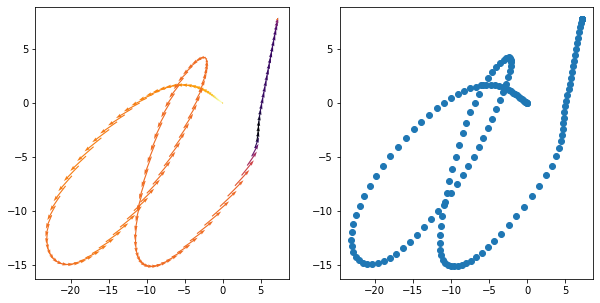

b


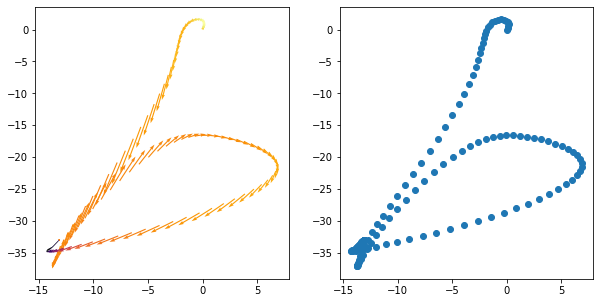

c


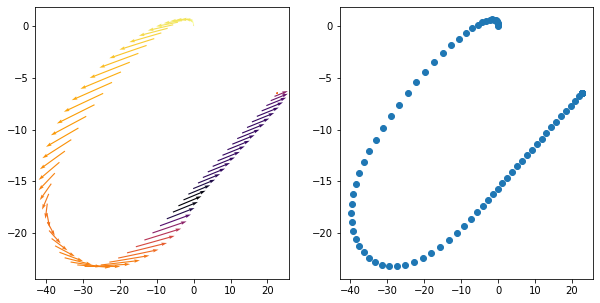

d


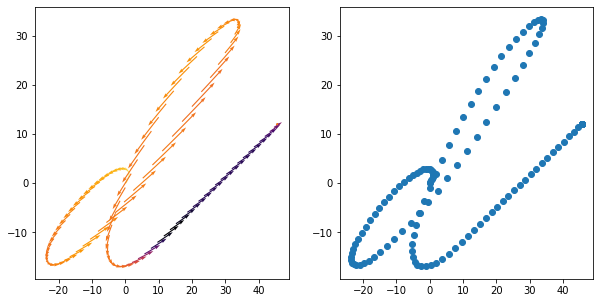

e


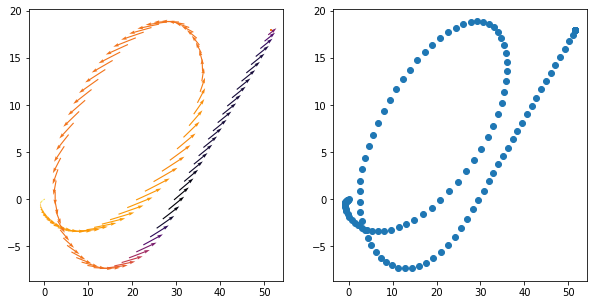

g


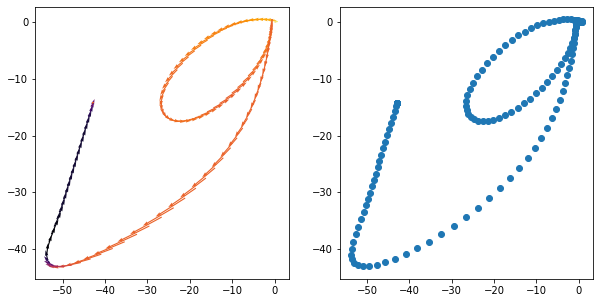

h


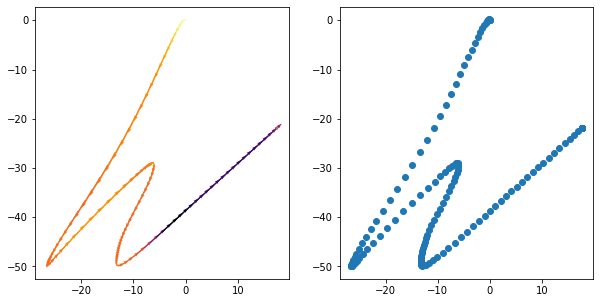

l


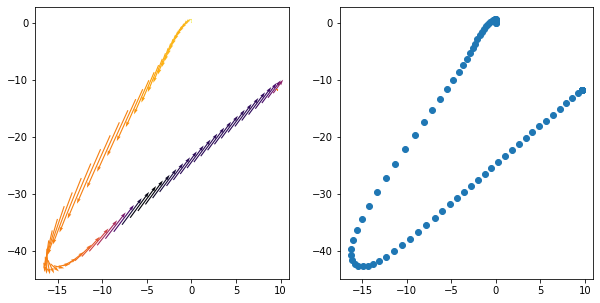

m


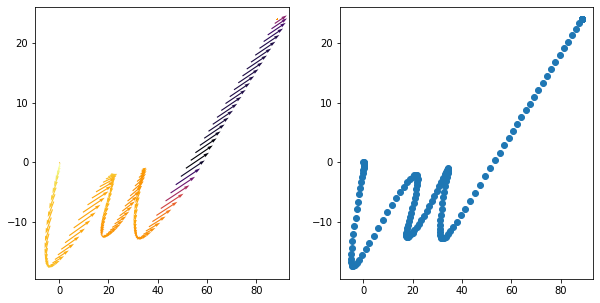

n


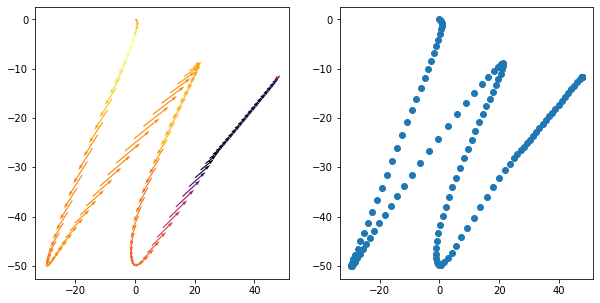

o


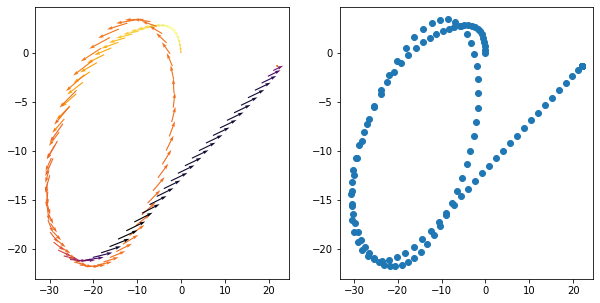

p


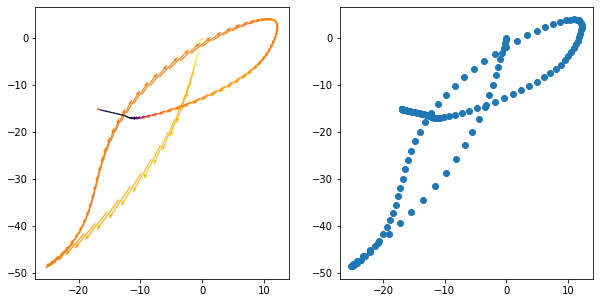

q


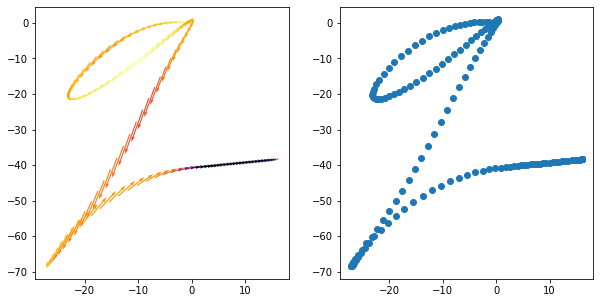

r


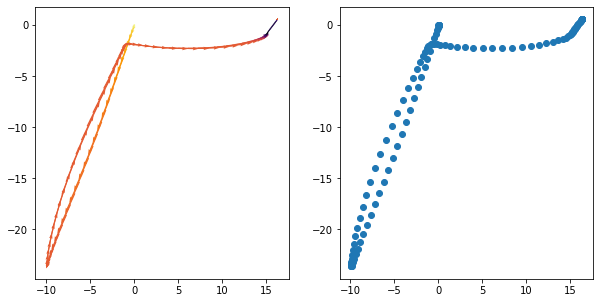

s


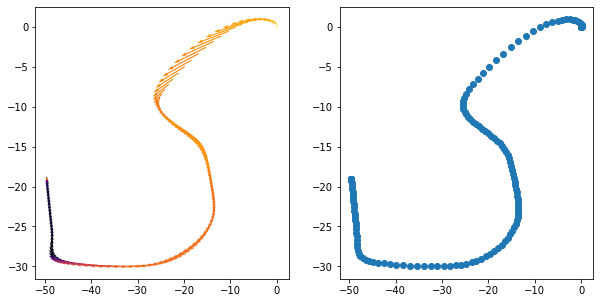

u


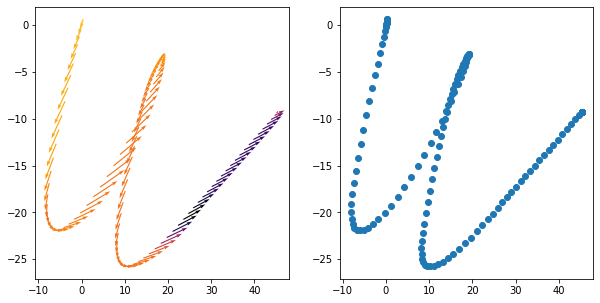

v


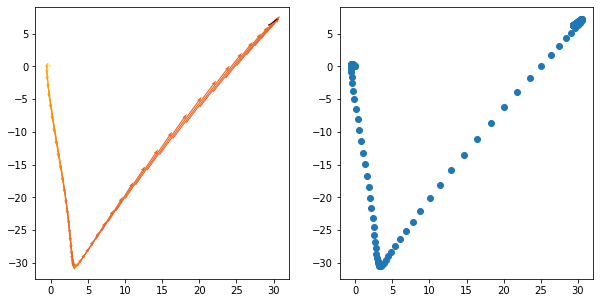

w


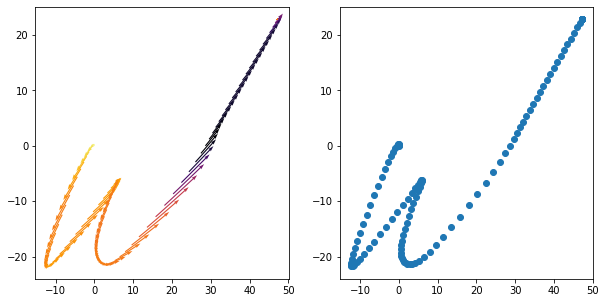

y


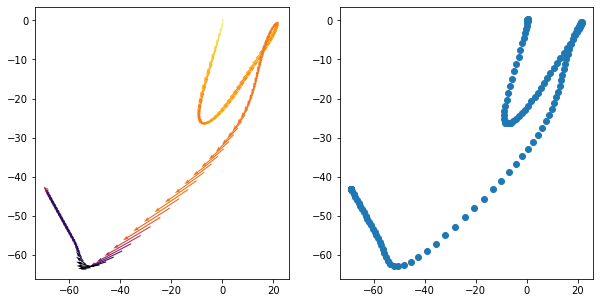

z


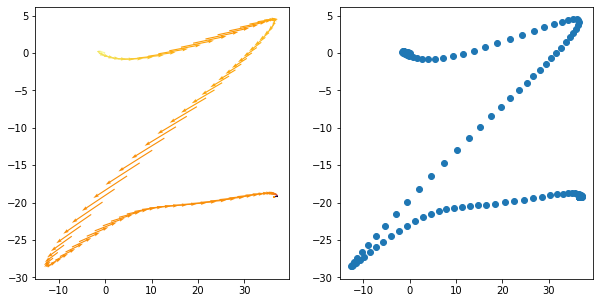

In [9]:
for i,class1 in enumerate(classes):
  indexes = np.where(train_labels==i)[0]
  np.random.seed(0)
  random_index = np.random.choice(indexes)
  print(class1)
  plot_charVector(train_inputs[random_index])

flatten inputs

In [10]:
def flatten_to_2d(inp):
  flattened_inp = inp.reshape(inp.shape[0],-1)
  return flattened_inp

train_inputs = flatten_to_2d(train_inputs)
val_inputs = flatten_to_2d(val_inputs)
test_inputs = flatten_to_2d(test_inputs)

## K-means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### form and visualize centroids

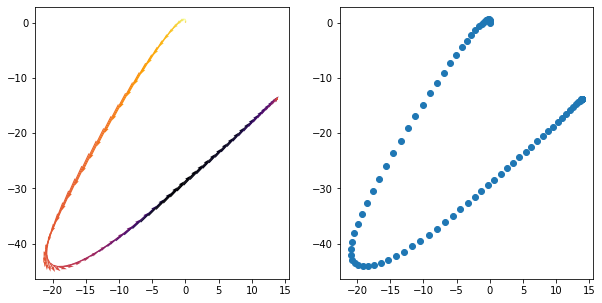

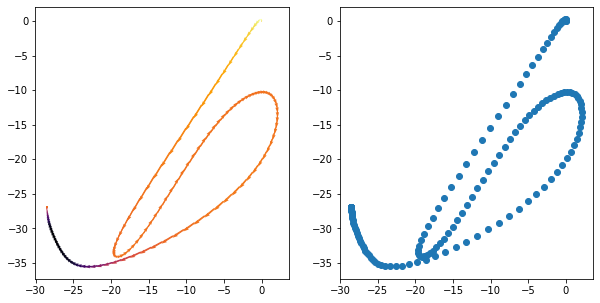

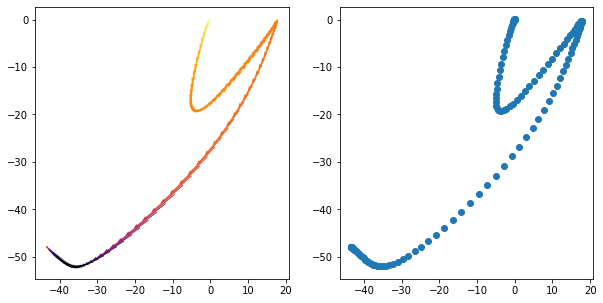

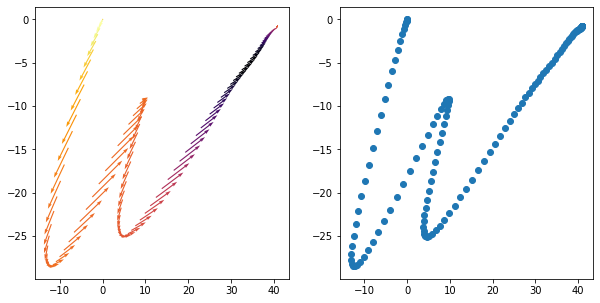

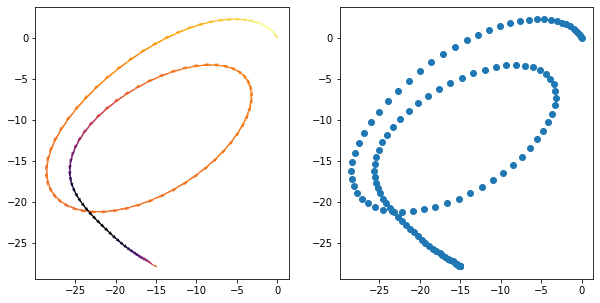

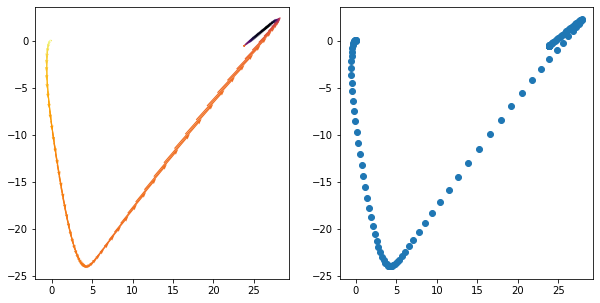

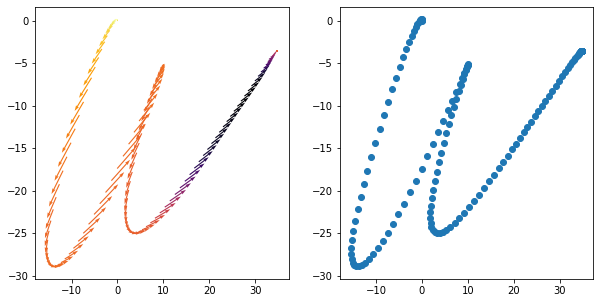

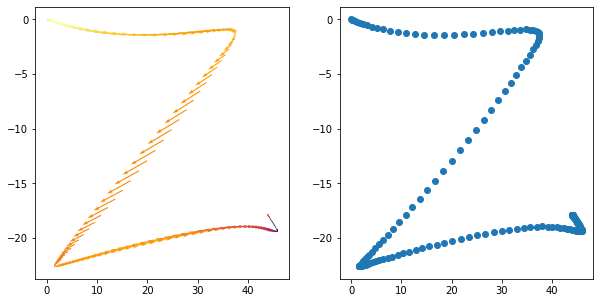

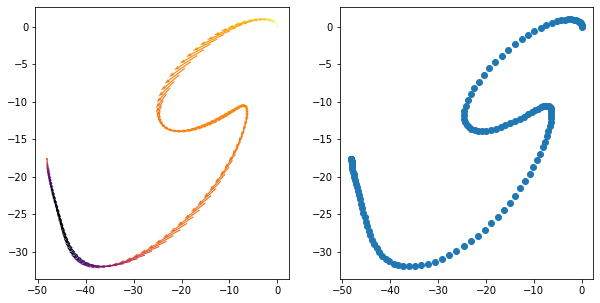

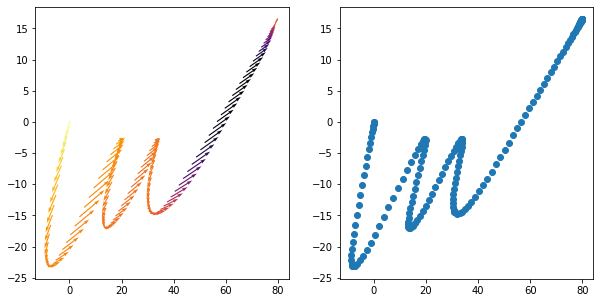

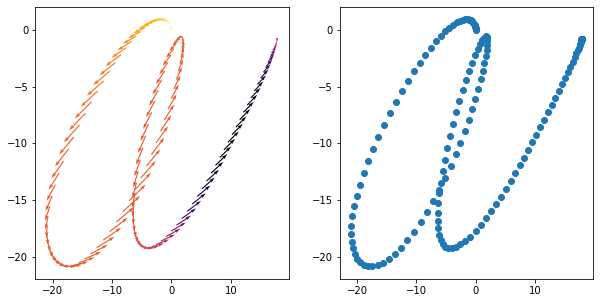

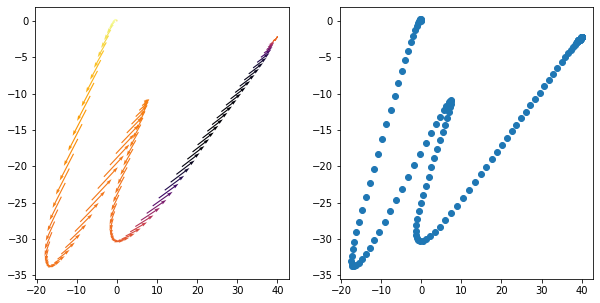

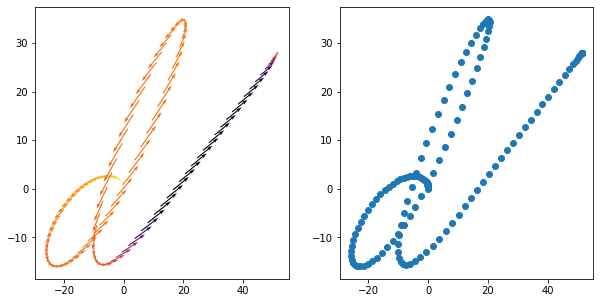

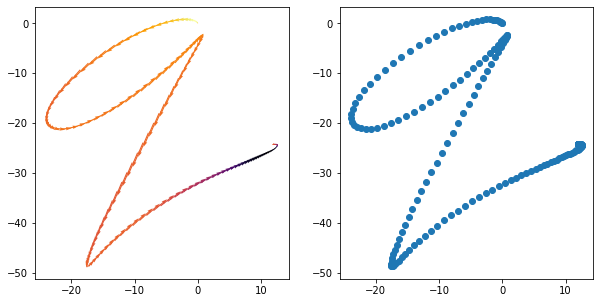

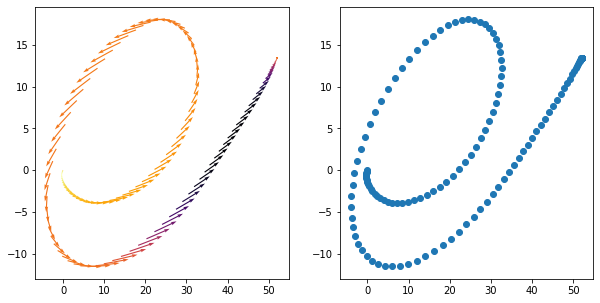

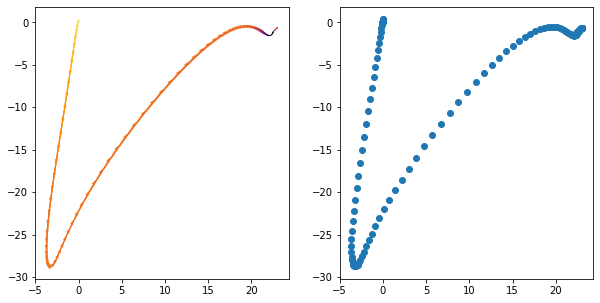

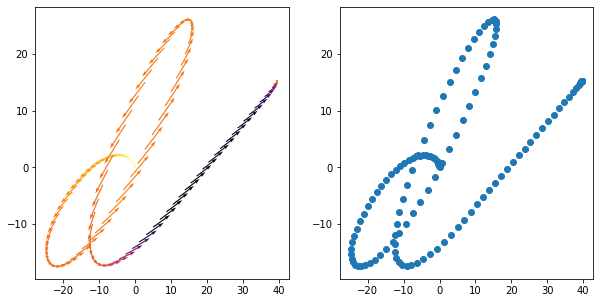

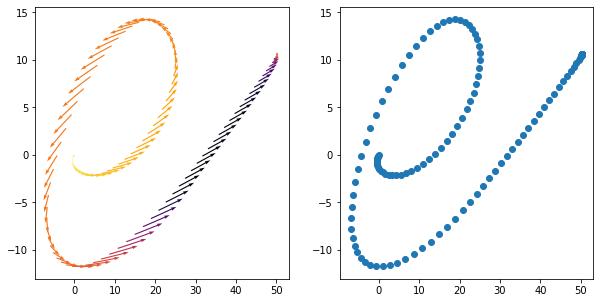

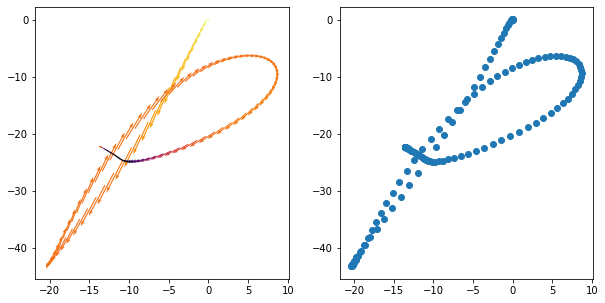

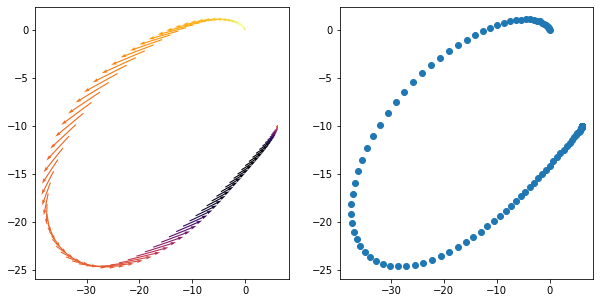

In [11]:
# form centroids
kmeans = KMeans(n_clusters=20, random_state=0).fit(train_inputs)

# visualize centroids
for i,class1 in enumerate(classes):
  plot_charVector(kmeans.cluster_centers_.reshape(20,3,182)[i])
# we may get some duplicates here

### evaluate

In [12]:
# we cannot evaluate directly using classification report since
# kmeans would not necessarily have centroid[0] as 'a' and so on.

def evaluate(method,inputs,labels):
  output_pred = method.predict(inputs)
  return metrics.adjusted_mutual_info_score(labels, output_pred)

print("evaluation results on train data")
print(evaluate(kmeans,train_inputs,train_labels))
print("evaluation results on test data")
print(evaluate(kmeans,test_inputs,test_labels))

evaluation results on train data
0.7134361361815945
evaluation results on test data
0.7224704752906655


## Nearest Centroid

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html

### form and visualize centroids

a


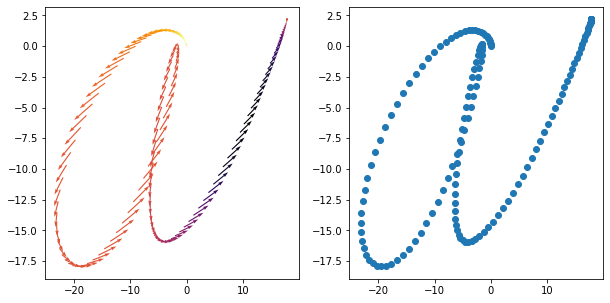

b


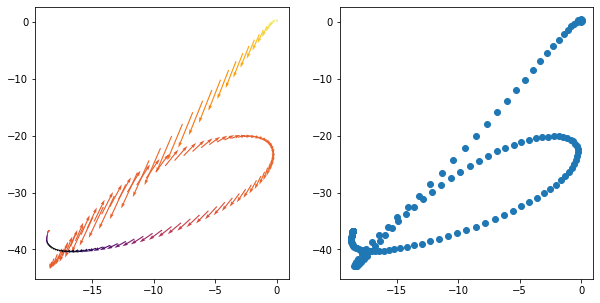

c


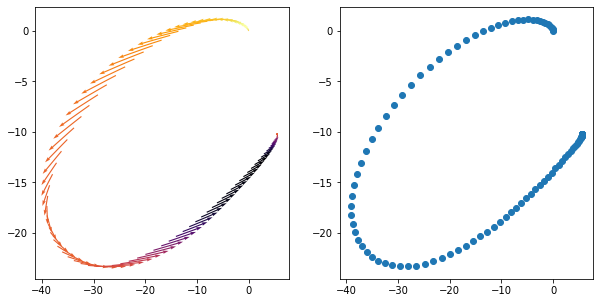

d


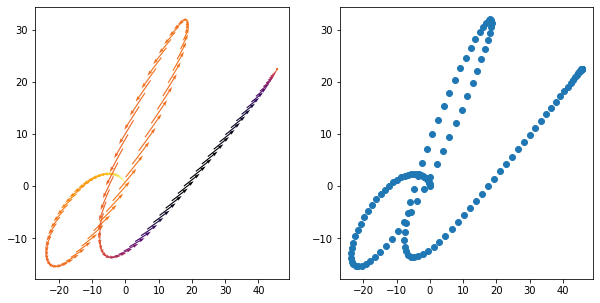

e


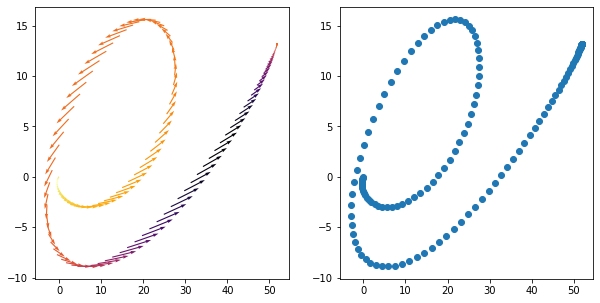

g


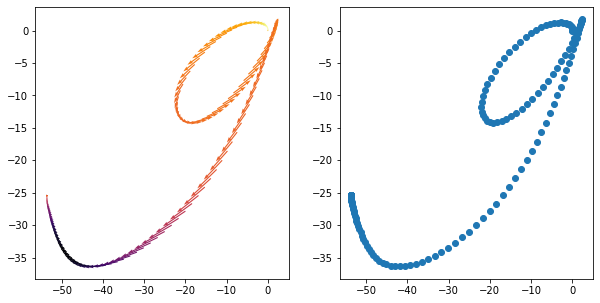

h


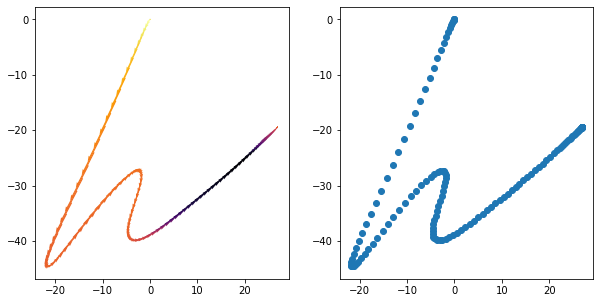

l


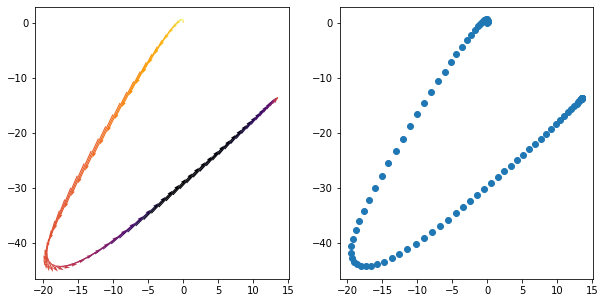

m


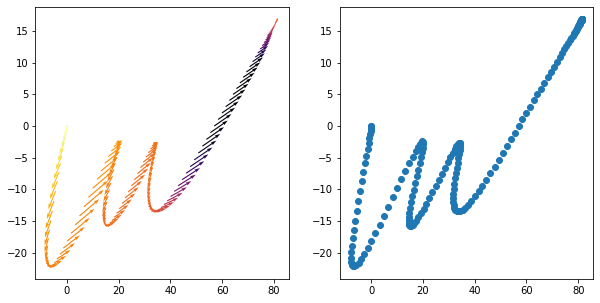

n


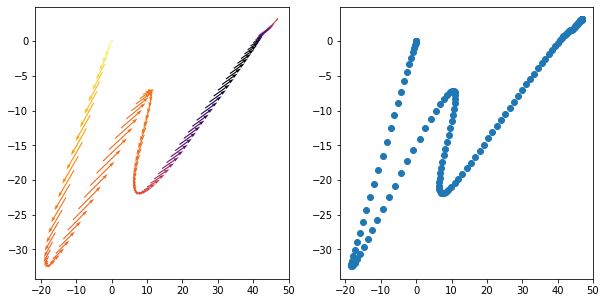

o


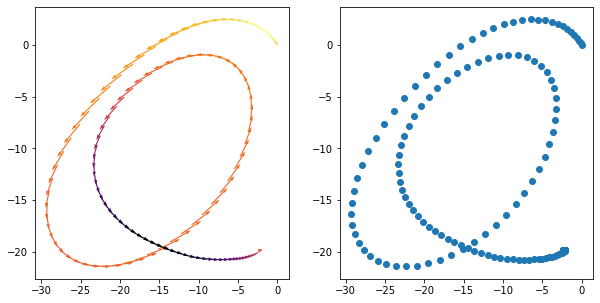

p


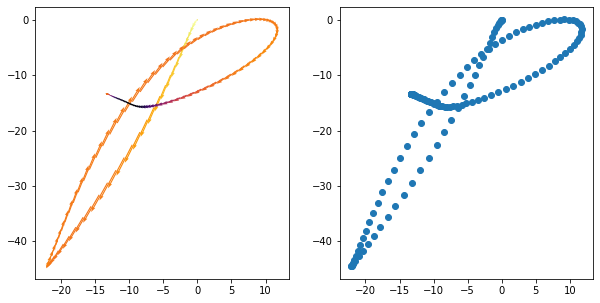

q


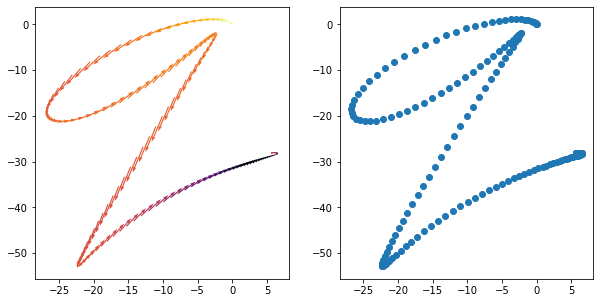

r


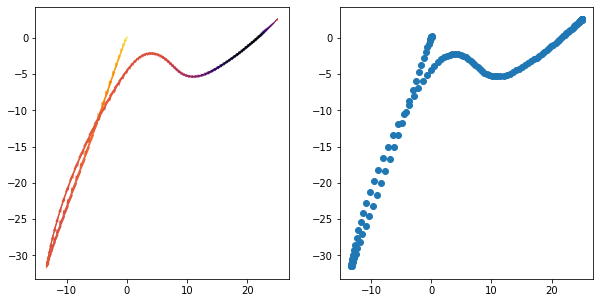

s


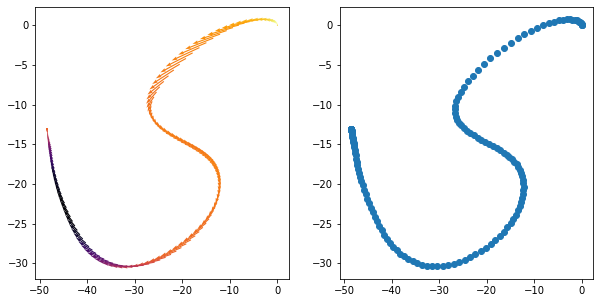

u


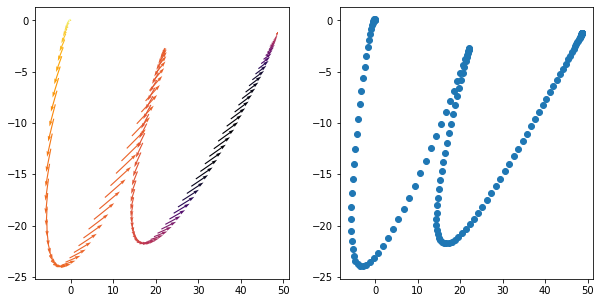

v


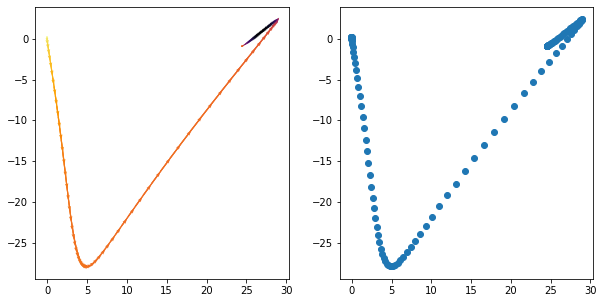

w


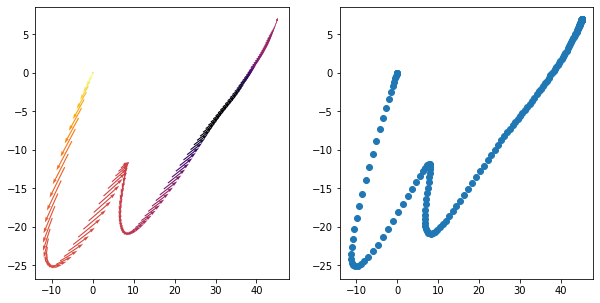

y


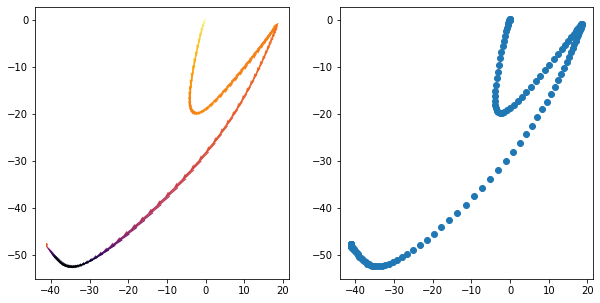

z


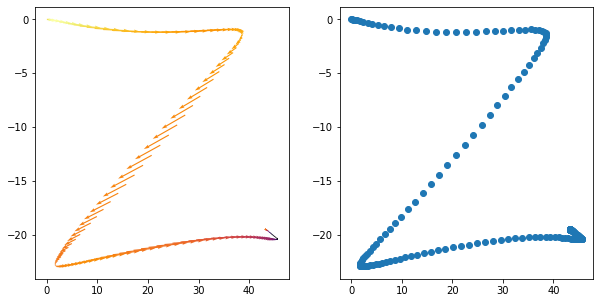

In [13]:
# form centroids
clf = NearestCentroid()
clf = clf.fit(train_inputs, train_labels)

# visualize centroids
for i,class1 in enumerate(classes):
  print(class1)
  plot_charVector(clf.centroids_.reshape(20,3,182)[i])

### evaluate

In [14]:
def evaluate(method, inputs, output_true, getDict=False):
  output_pred = method.predict(inputs)
  return classification_report(output_true, output_pred, target_names=classes, digits=4, output_dict=getDict)

print("evaluation results on train data")
print(evaluate(clf,train_inputs,train_labels))
print("evaluation results on test data")
print(evaluate(clf,test_inputs,test_labels))

evaluation results on train data
              precision    recall  f1-score   support

           a     0.6818    0.8036    0.7377        56
           b     0.8710    0.8852    0.8780        61
           c     0.9123    0.9123    0.9123        57
           d     0.8276    0.8727    0.8496        55
           e     0.9565    0.8919    0.9231        74
           g     0.8837    0.8261    0.8539        46
           h     0.6970    0.5476    0.6133        42
           l     0.9516    0.9365    0.9440        63
           m     0.9216    0.9216    0.9216        51
           n     0.5172    0.5660    0.5405        53
           o     0.9302    0.7692    0.8421        52
           p     0.9434    0.9091    0.9259        55
           q     0.9091    0.9091    0.9091        44
           r     0.7955    0.8140    0.8046        43
           s     0.9375    0.9574    0.9474        47
           u     0.6000    0.6250    0.6122        48
           v     0.8310    0.9833    0.9008     

## K Nearest Neighbors

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

### find best value of K

In [15]:
def train(train_inputs,train_labels,val_inputs,val_labels, K_vals = list(range(1,21))):
  print("checking values of K in range", K_vals[0], "to", K_vals[-1])
  train_loss = []
  val_loss = []
  best_k = 1

  for k in tqdm(K_vals):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_inputs, train_labels)

    accuracy = evaluate(neigh,train_inputs,train_labels,getDict=True)["accuracy"]
    train_loss.append(1-accuracy)
    accuracy = evaluate(neigh,val_inputs,val_labels,getDict=True)["accuracy"]
    val_loss.append(1-accuracy)

    if k==1:
      best_loss = val_loss[-1]
    elif val_loss[-1] < best_loss:
      best_k = k
      best_loss = val_loss[-1]


  plt.plot(K_vals,train_loss, label='train loss')
  plt.plot(K_vals,val_loss, label='val loss')
  #plt.plot(K_vals,[best_loss]*len(K_vals), linestyle='dashed')
  plt.plot(best_k, best_loss, 'o')
  plt.xlabel("n_neighbors")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_k

checking values of K in range 1 to 100


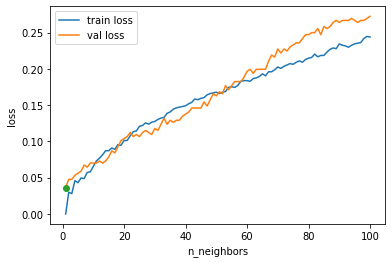

In [16]:
best_k = train(train_inputs,train_labels,val_inputs,val_labels,list(range(1,101)))
# in our data best prediction was made when considering just one neighbor

In [17]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(train_inputs, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### evaluate

In [18]:
print("evaluation results on train data")
print(str(evaluate(neigh,train_inputs,train_labels)))
print("evaluation results on test data")
print(evaluate(neigh,test_inputs,test_labels))

evaluation results on train data
              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000        56
           b     1.0000    1.0000    1.0000        61
           c     1.0000    1.0000    1.0000        57
           d     1.0000    1.0000    1.0000        55
           e     1.0000    1.0000    1.0000        74
           g     1.0000    1.0000    1.0000        46
           h     1.0000    1.0000    1.0000        42
           l     1.0000    1.0000    1.0000        63
           m     1.0000    1.0000    1.0000        51
           n     1.0000    1.0000    1.0000        53
           o     1.0000    1.0000    1.0000        52
           p     1.0000    1.0000    1.0000        55
           q     1.0000    1.0000    1.0000        44
           r     1.0000    1.0000    1.0000        43
           s     1.0000    1.0000    1.0000        47
           u     1.0000    1.0000    1.0000        48
           v     1.0000    1.0000    1.0000     